In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/data-storm-10/credit_card_default_test.csv
/kaggle/input/data-storm-10/Credit_card_default - Business Problem - Assessment Criteria - Data Dictionary.xlsx
/kaggle/input/data-storm-10/credit_card_default_train.csv
/kaggle/input/data-storm-10/DATA STORM 1.0 - First Round Competition Guidlines.pdf


# Load the given datasets

In [2]:
from sklearn.preprocessing import LabelEncoder #for categorical data
from sklearn.model_selection import train_test_split #to split the data into train and cross validation set
from sklearn.ensemble import RandomForestClassifier #classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [3]:
train = pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_train.csv')
test = pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_test.csv')

# Visualising Data

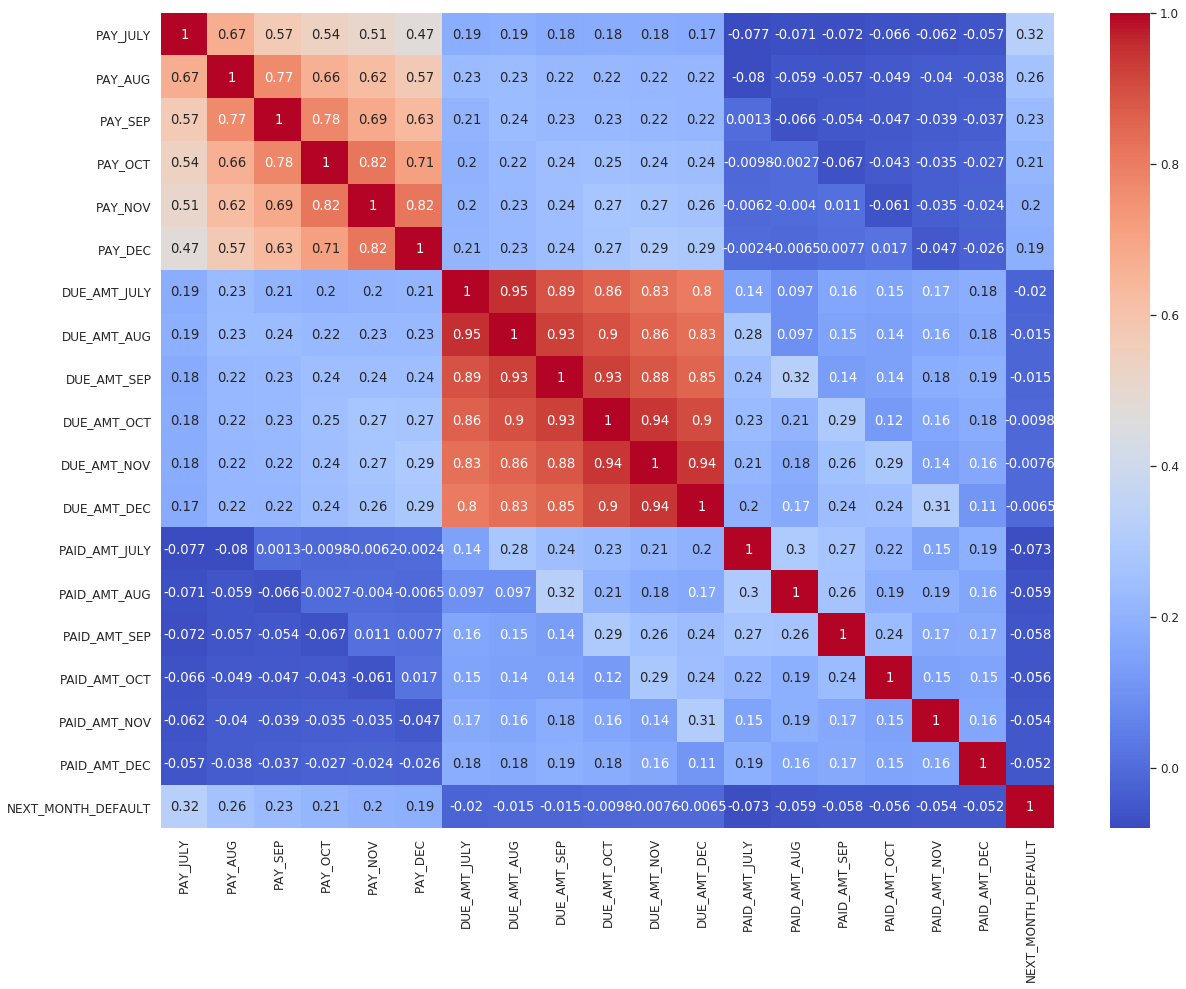

In [4]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 15]})
sns.heatmap(train.corr(), cmap = 'coolwarm', annot = True) #obtain heatmap

In [5]:
y_labels=train.NEXT_MONTH_DEFAULT
train.drop(["Client_ID"], axis=1, inplace=True)
train.drop(["NEXT_MONTH_DEFAULT"], axis=1, inplace=True)

ID = test.Client_ID
test.drop(["Client_ID"], axis=1, inplace=True)

In [6]:
test.shape

(6000, 23)

### Feature Engineering

In [7]:
cleanup = {"Balance_Limit_V1" : {"100K" : 100000,
                                 "200K" : 200000,
                                 "300K" : 300000,
                                 "400K" : 400000,
                                 "500K" : 500000,
                                 " 500K" : 500000,
                                 "1M" : 1000000,
                                 "1.5M" : 1500000,
                                 "2.5M" : 2500000,
                                }
          }
train.replace(cleanup, inplace=True)
test.replace(cleanup, inplace=True)

In [8]:
#derive Secondary data
train['AMT_TO_PAY'] = train['DUE_AMT_JULY'] + train['DUE_AMT_AUG'] + train['DUE_AMT_SEP'] + train['DUE_AMT_OCT'] + train['DUE_AMT_NOV'] + train['DUE_AMT_DEC'] 
test['AMT_TO_PAY'] = test['DUE_AMT_JULY'] + test['DUE_AMT_AUG'] + test['DUE_AMT_SEP'] + test['DUE_AMT_OCT'] + test['DUE_AMT_NOV'] + test['DUE_AMT_DEC'] 

train["MISSED_PAY"] = train['PAY_JULY'] + train['PAY_AUG'] +train['PAY_SEP'] + train['PAY_OCT'] + train['PAY_NOV'] + train['PAY_DEC']
test["MISSED_PAY"] = test['PAY_JULY'] + test['PAY_AUG'] +test['PAY_SEP'] + test['PAY_OCT'] + test['PAY_NOV'] + test['PAY_DEC']

train['AMT_PAID'] = train['PAID_AMT_JULY'] + train['PAID_AMT_AUG'] + train['PAID_AMT_SEP'] + train['PAID_AMT_OCT'] + train['PAID_AMT_NOV'] + train['PAID_AMT_DEC'] 
test['AMT_PAID'] = test['PAID_AMT_JULY'] + test['PAID_AMT_AUG'] + test['PAID_AMT_SEP'] + test['PAID_AMT_OCT'] + test['PAID_AMT_NOV'] + test['PAID_AMT_DEC'] 

train['NET_RATIO'] =(train['AMT_TO_PAY'] - train['AMT_PAID'])/(6*train["Balance_Limit_V1"])
test['NET_RATIO'] =(test['AMT_TO_PAY'] - test['AMT_PAID'])/(6*test["Balance_Limit_V1"])

In [9]:
train.NET_RATIO = train.NET_RATIO <= 0.3
train.NET_RATIO = train.NET_RATIO.astype(int)
test.NET_RATIO = test.NET_RATIO <= 0.3
test.NET_RATIO = test.NET_RATIO.astype(int)

In [10]:
# train.drop(["PAY_JULY", "PAY_AUG", 'PAY_SEP', 'PAY_OCT', 'PAY_NOV', 'PAY_DEC'], axis=1, inplace=True)
# train.drop(["DUE_AMT_JULY", "DUE_AMT_AUG", 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC'], axis=1, inplace=True)
# train.drop(["PAID_AMT_JULY", "PAID_AMT_AUG", 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC'], axis=1, inplace=True)
# test.drop(["PAY_JULY", "PAY_AUG", 'PAY_SEP', 'PAY_OCT', 'PAY_NOV', 'PAY_DEC'], axis=1, inplace=True)
# test.drop(["DUE_AMT_JULY", "DUE_AMT_AUG", 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC'], axis=1, inplace=True)
# test.drop(["PAID_AMT_JULY", "PAID_AMT_AUG", 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC'], axis=1, inplace=True)
# train.drop(['Balance_Limit_V1'], axis=1, inplace=True)
# test.drop(['Balance_Limit_V1'], axis=1, inplace=True)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 27 columns):
Balance_Limit_V1    24000 non-null int64
Gender              24000 non-null object
EDUCATION_STATUS    24000 non-null object
MARITAL_STATUS      24000 non-null object
AGE                 24000 non-null object
PAY_JULY            24000 non-null int64
PAY_AUG             24000 non-null int64
PAY_SEP             24000 non-null int64
PAY_OCT             24000 non-null int64
PAY_NOV             24000 non-null int64
PAY_DEC             24000 non-null int64
DUE_AMT_JULY        24000 non-null int64
DUE_AMT_AUG         24000 non-null int64
DUE_AMT_SEP         24000 non-null int64
DUE_AMT_OCT         24000 non-null int64
DUE_AMT_NOV         24000 non-null int64
DUE_AMT_DEC         24000 non-null int64
PAID_AMT_JULY       24000 non-null int64
PAID_AMT_AUG        24000 non-null int64
PAID_AMT_SEP        24000 non-null int64
PAID_AMT_OCT        24000 non-null int64
PAID_AMT_NOV        24000 

In [12]:
categorical = [
  'Balance_Limit_V1',
    'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE',
    'PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV', 'PAY_DEC',
    'NET_RATIO', 'MISSED_PAY'
]
numerical = [
   'DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC',
    'PAID_AMT_JULY', 'PAID_AMT_AUG', 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC',
    'AMT_TO_PAY','AMT_PAID'
]


train = train[numerical + categorical]
train.shape



(24000, 27)

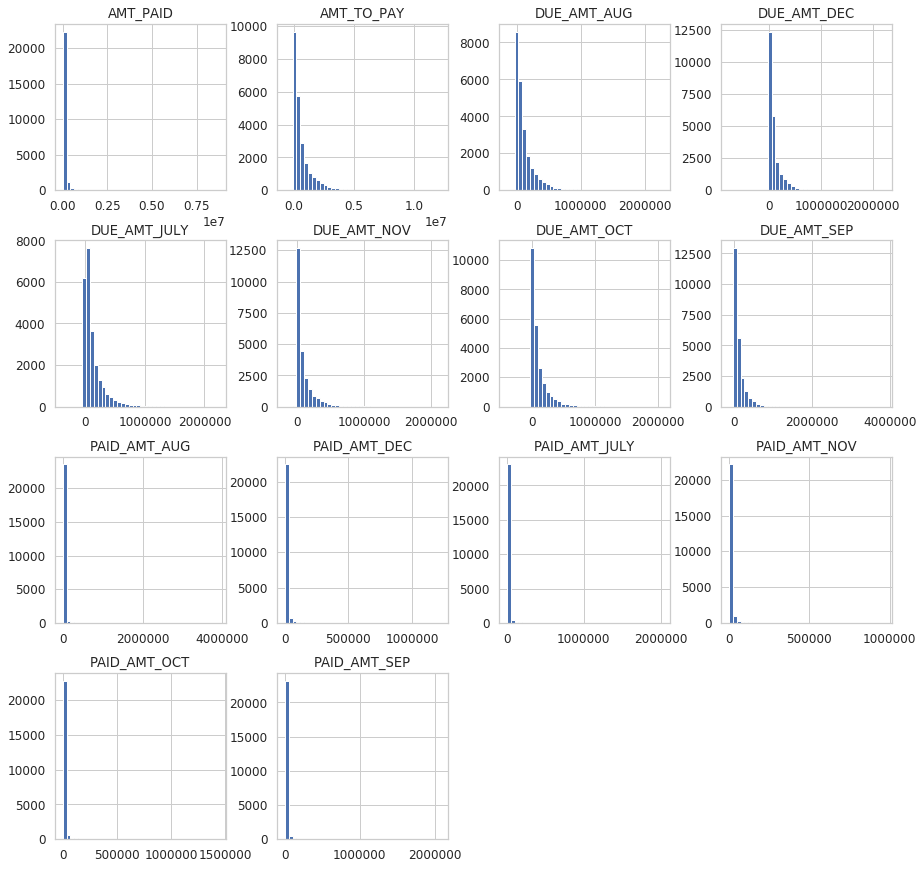

In [13]:
#histograms of the numerical data
train[numerical].hist(bins=40, figsize=(15, 15), layout=(4, 4));

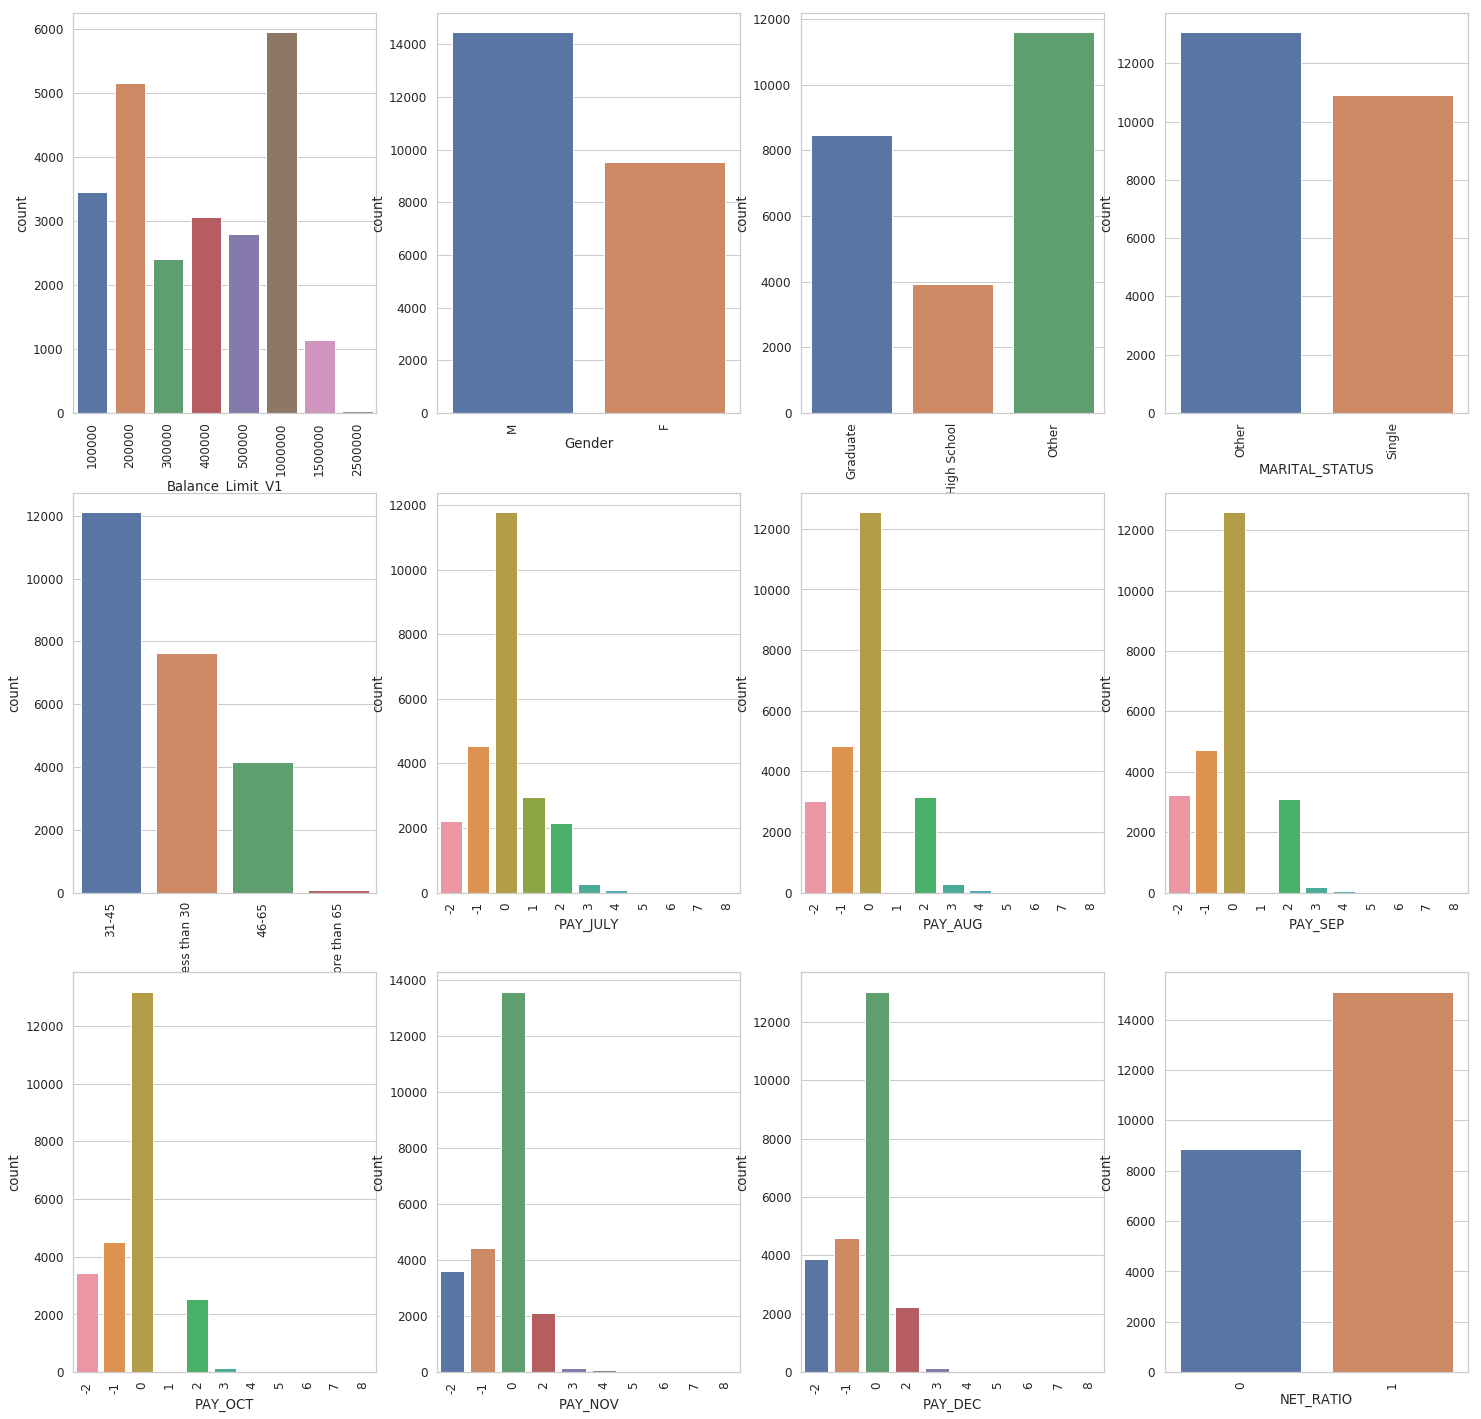

In [15]:
#count plots of the categorical data
fig, ax = plt.subplots(3, 4, figsize=(25, 25))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

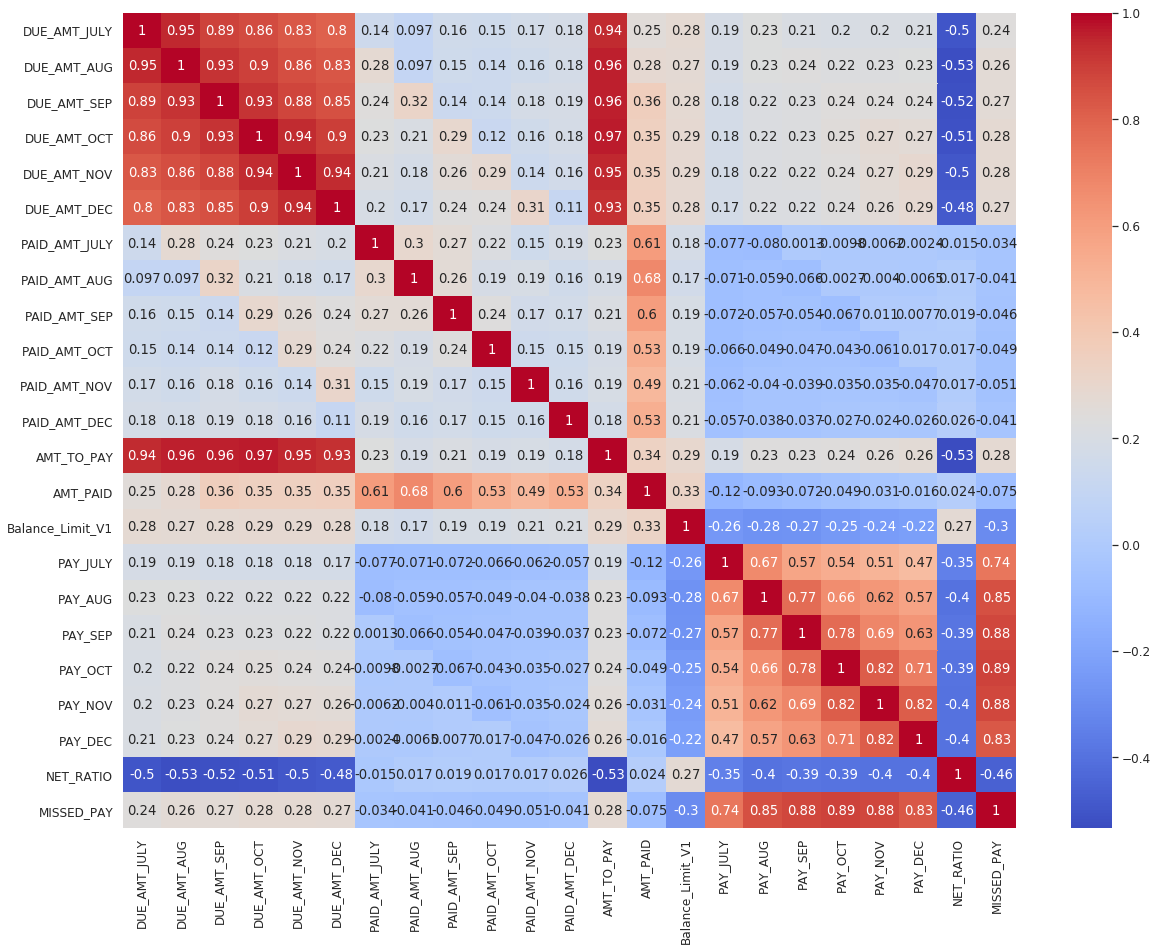

In [16]:
#heatmap of the data
sns.heatmap(train.corr(), cmap = 'coolwarm', annot = True)

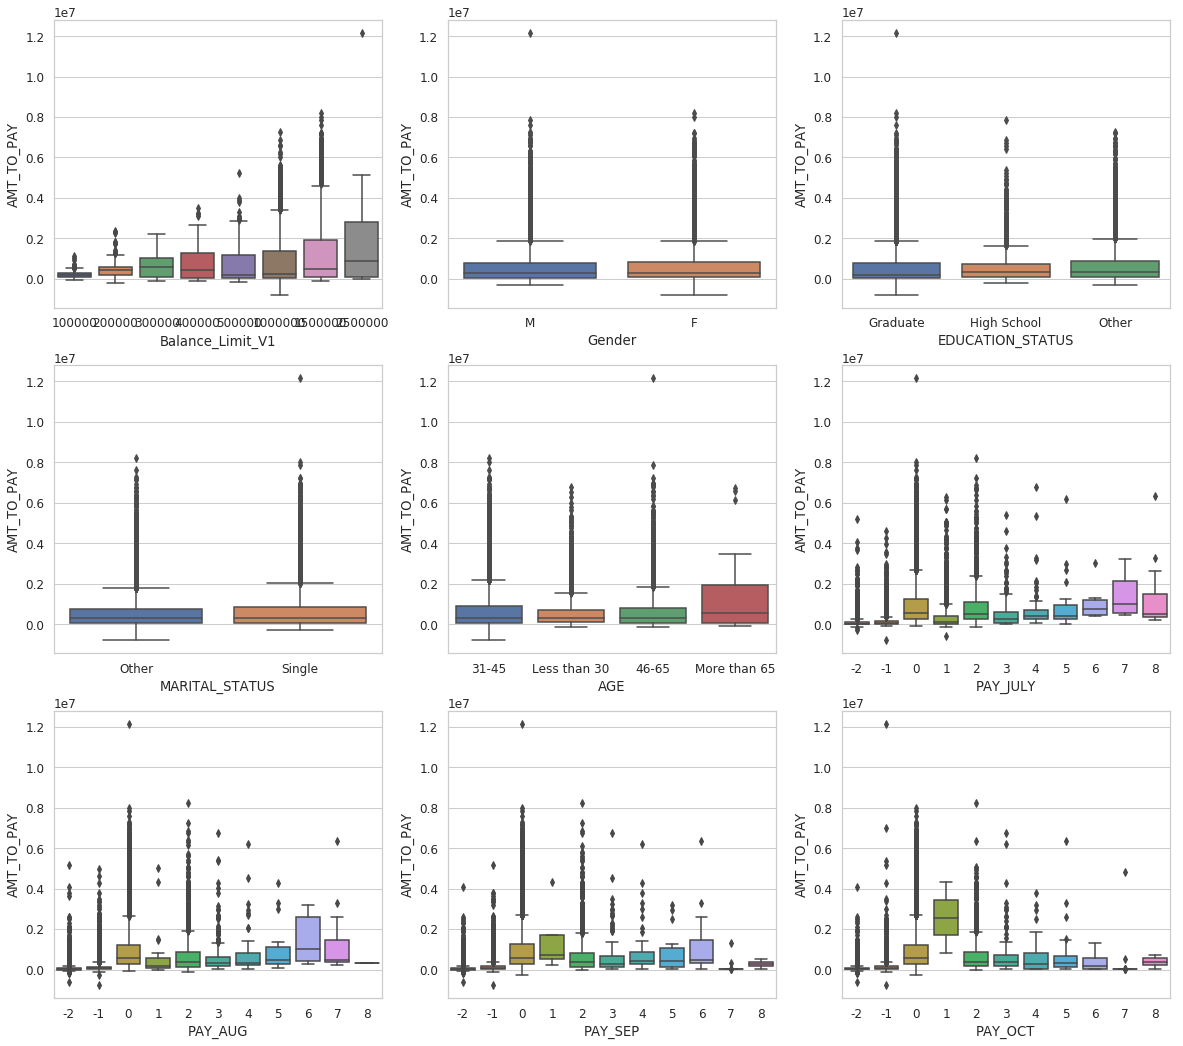

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(20, 18))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='AMT_TO_PAY', data=train, ax=subplot)

In [18]:
# Label encoding
s = (train.dtypes == 'object')
object_cols = list(s[s].index)

label_encoder = LabelEncoder()
for col in set(object_cols):
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])


In [19]:
train.head()

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,...,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,NET_RATIO,MISSED_PAY
0,3248,3389,6004,39418,162772,-13982,3437,6004,39418,162772,...,0,0,-1,-1,-1,-1,-1,-1,1,-6
1,353351,151818,26948,43530,80811,124590,151818,46200,43530,80811,...,0,2,0,-1,-1,-1,-1,0,1,-4
2,16681,16082,15477,0,0,0,0,0,0,0,...,1,0,4,3,2,2,-2,-2,1,7
3,90457,92848,95193,97309,100353,102740,3855,3890,3696,4620,...,1,0,2,0,0,0,0,0,0,2
4,429556,419466,429785,435354,445271,453899,0,20790,16170,17325,...,0,0,2,2,0,0,0,0,0,4


In [20]:
test = test[numerical + categorical]
test.head()

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,...,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,NET_RATIO,MISSED_PAY
0,194188,198510,128316,311201,351790,352206,13710,12816,195701,53246,...,1,0,0,0,0,0,0,0,0,0
1,87115,89427,91823,94181,97221,100275,3756,3842,3890,4620,...,1,0,0,0,0,0,0,0,0,0
2,2693,9573,8984,11294,9561,993,6930,0,2310,0,...,0,2,-1,-1,2,0,0,-1,1,-1
3,0,5775,5775,0,0,0,5775,5775,0,0,...,1,0,1,-1,-1,-2,-2,-2,1,-7
4,85257,0,0,0,0,0,0,0,0,0,...,0,2,0,0,-2,-2,-2,-2,1,-8


# Model

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y_labels,test_size=0.2)

## Random Forest

In [ ]:
model  = RandomForestClassifier(n_estimators=300,random_state=5,verbose=1,min_samples_split=100)
model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
pred = model.predict(X_valid)

In [ ]:
accuracy = accuracy_score(pred,y_valid)
accuracy

In [ ]:
print(confusion_matrix(pred,y_valid))

In [ ]:
print(classification_report(pred, y_valid))

In [ ]:
predictions = model.predict(test)

In [ ]:
submission = pd.DataFrame({'Client_ID':ID,'NEXT_MONTH_DEFAULT':predictions})
filename = 'RandomForest_3.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)
submission.head()